# **Project: Forecasting Stock Prices**
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Importing libraries

**Please note that we are downgrading the version of the statsmodels library to version 0.12.1.** Due to some variation, the latest version of the library might not give us the desired results. You can run the below code to downgrade the library and avoid any issues in the output. Once the code runs successfully, either restart the kernel or restart the Jupyter Notebook before importing the statsmodels library.It is enough to run the install statsmodel cell once.To be sure you are using the correct version of the library, you can use the code in the Version check cell of the model.

In [2]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.6 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [51]:
# Version check 
import statsmodels
statsmodels.__version__

'0.12.1'

In [50]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [5]:
#If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
#conda install -c anaconda xlrd

In [52]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Checking info 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [9]:
#Write your code here
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2006-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


**Observations:**

- There are a total of 144 non-null observations in each of the columns. This indicates that there are no missing values in the data.
- Every column in this dataset is numeric in nature.

In [8]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

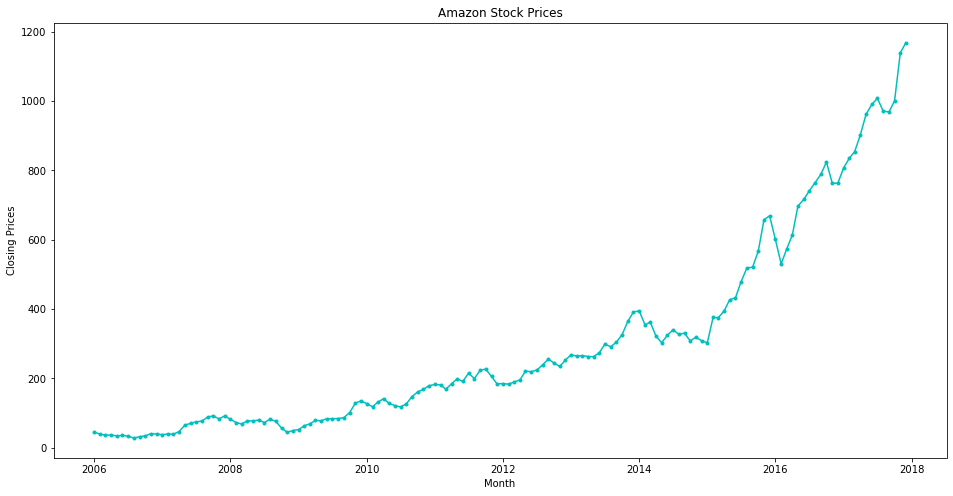

In [49]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

### Splitting the dataset

In [53]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-+ train_data.iloc[-1][0]+ train_data.iloc[-1][0]12-01']
print(df_train)
print(df_test)

Empty DataFrame
Columns: [date, close]
Index: []
Empty DataFrame
Columns: [date, close]
Index: []


Now let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Testing the stationarity of the series

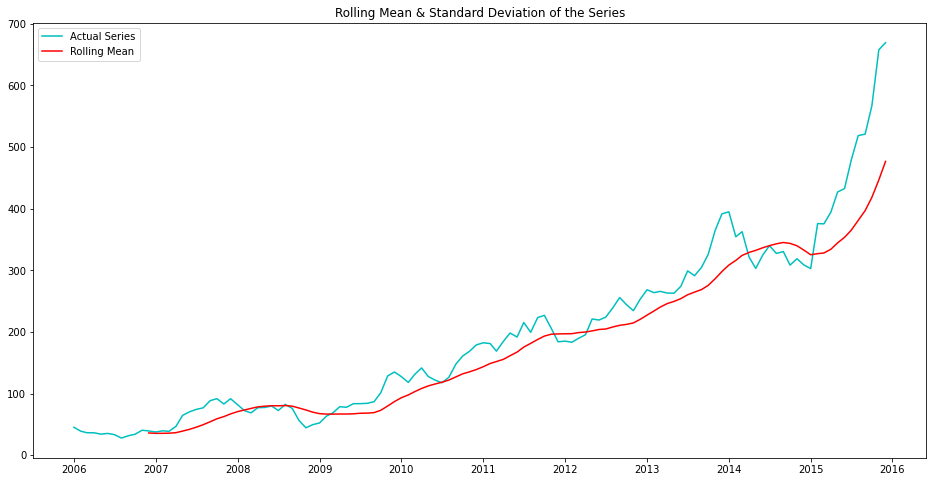

In [48]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [13]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

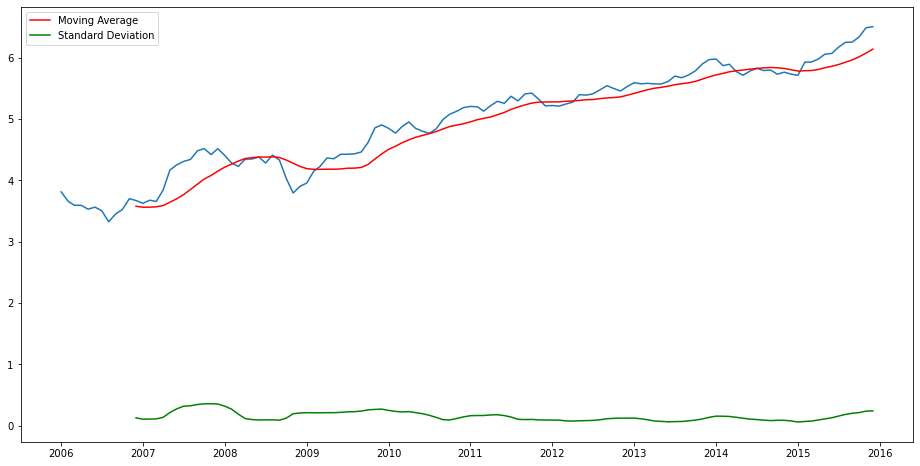

In [27]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

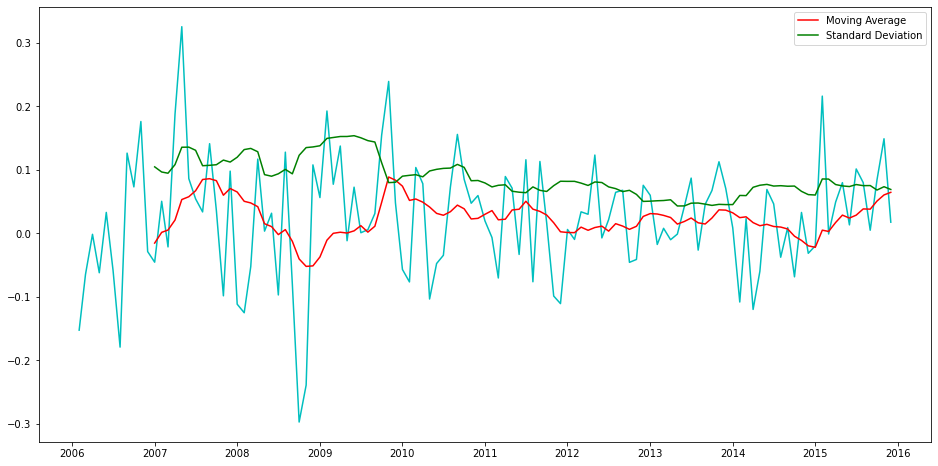

In [28]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:** 

- Since there is no significant trend (either upward or downward) in the series, we can conclude that the series is now stationary. 
- The variance after 2009 is almost constant, which implies that now the series has constant variance.

Let us use the adfuller test to check the stationarity.

In [19]:
adfuller(df_shift) # call the adfuller function for df_shift series

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observations:**
- From the Dickey-Fuller test, we can see that the p-value is now lower than 0.05 (for 95% confidence intervals); therefore, we have sufficient evidence to reject the null hypothesis.
- Hence, we can confirm that the series is now stationary.

Let's decompose the time series to check its different components.

### Decomposing the time series components into Trend, Seasonality and Residual

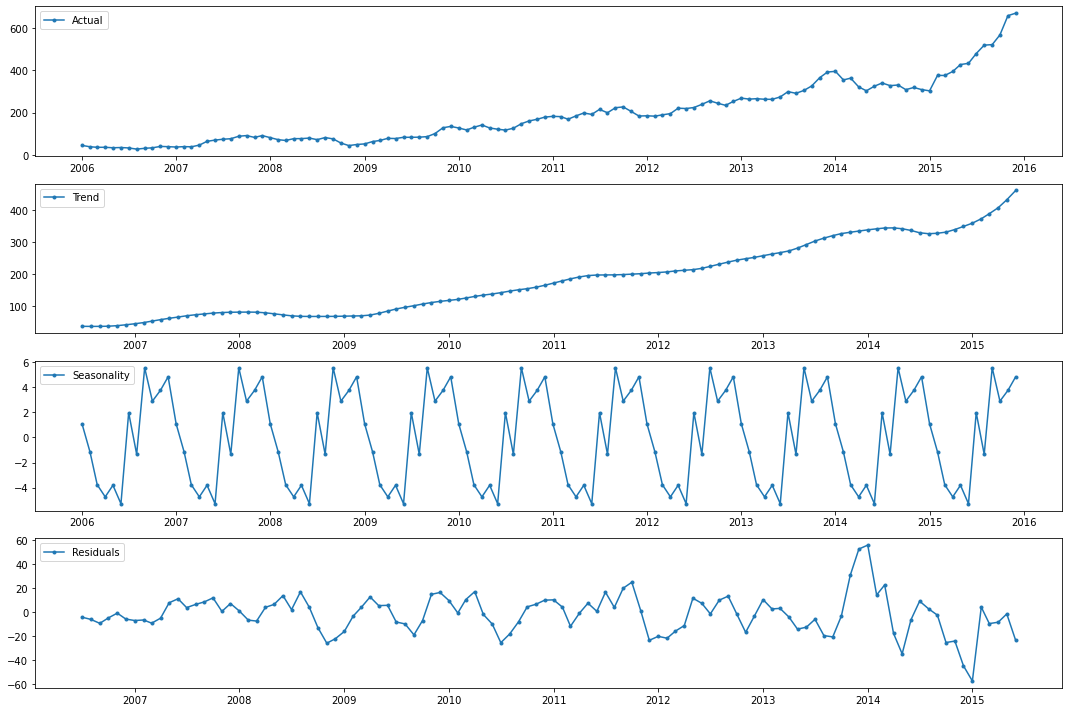

In [29]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

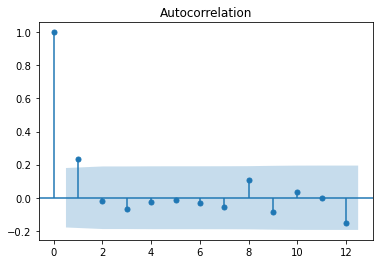

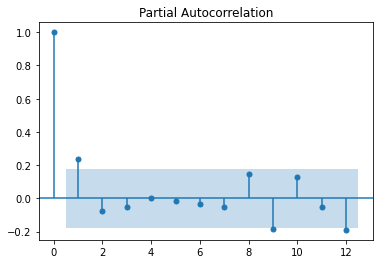

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Question 3: Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

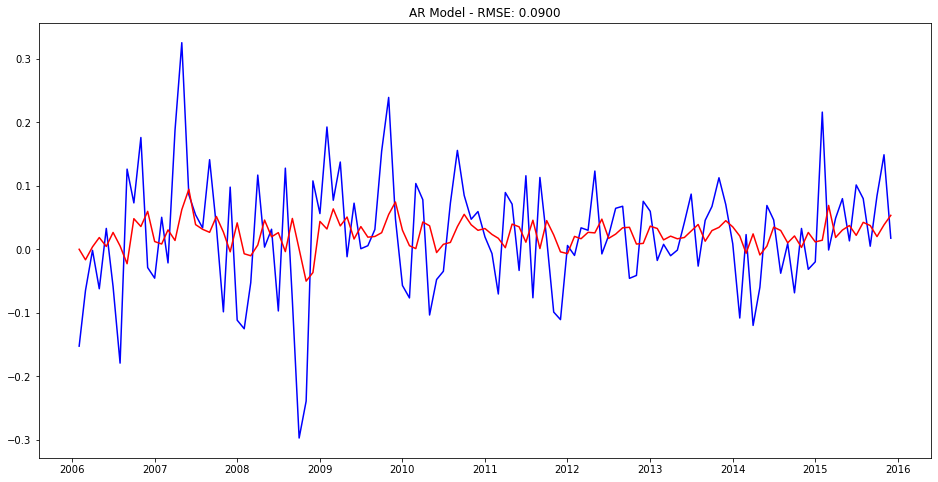

In [123]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags = 1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift, color='b')
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.show()

**Observations:**

AR(1) model means that y depends on one of its previous values and consequently gives a 0.09 RMSE.


**Let's check the AIC value** of the model

In [ ]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Question 4: Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

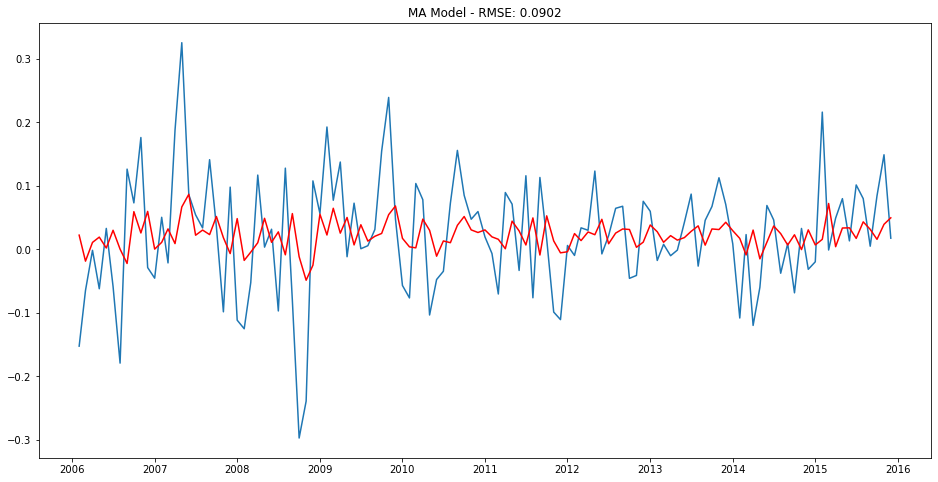

In [38]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(df_shift)
predict = results_MA.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**

The MA model looks very similar to the AR model with 0.0902 RMSE.

Let's check the AIC value of the model

In [34]:
results_MA.aic

-229.09493930954125

- **The MA model is giving a much lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.** 

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

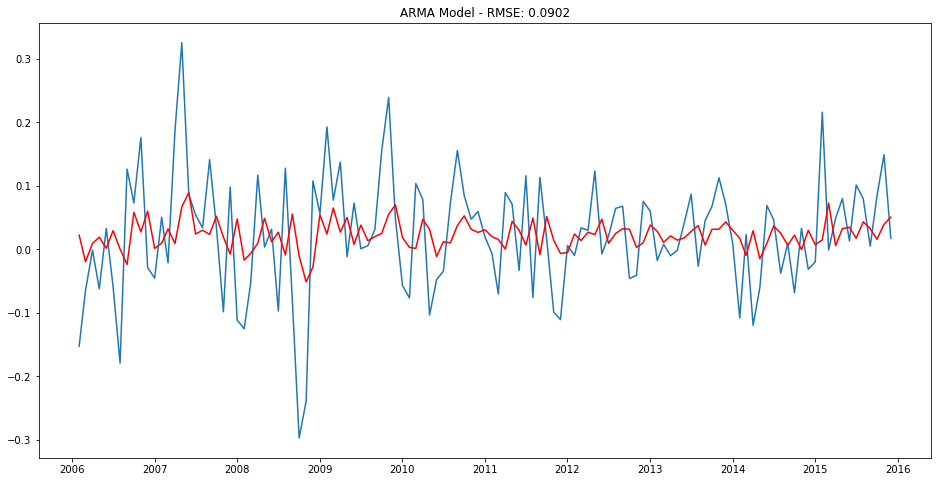

In [31]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
plt.plot(df_shift)
predict = results_ARMA.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- **The ARMA model looks very similar to the MA model with the same RMSE of 0.0902.**

**Let's check the AIC value** of the model

In [ ]:
results_ARMA.aic

-227.11129132564088

- **The AIC value of the ARMA model is more or less similar to MA model**

**Let us try using the ARIMA Model.**

### ARIMA Model

We will be using an **ARIMA Model with p=1, d=1, & q=1**.

### **Question 6: Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

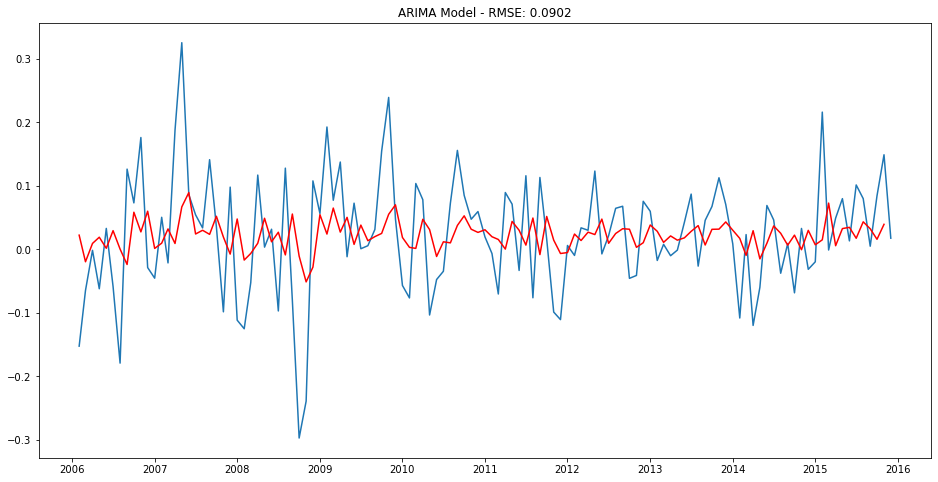

In [44]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1, 1, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_shift)
predict = results_ARIMA.predict(start=1,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**

- The AIC value of the ARMA model is more or less similar to MA model

**Let's check the AIC value** of the model

In [ ]:
results_ARIMA.aic

-227.11129236959937

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [58]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARIMA Model. (5 Marks)**

In [59]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

date
2006-02-01    0.022235
2006-03-01    0.002568
2006-04-01    0.011753
2006-05-01    0.030738
2006-06-01    0.032353
                ...   
2015-08-01    2.526098
2015-09-01    2.558385
2015-10-01    2.574081
2015-11-01    2.613357
2015-12-01    2.663924
Length: 119, dtype: float64

In [60]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

date
2006-01-01    3.811539
2006-02-01    3.833774
2006-03-01    3.814108
2006-04-01    3.823292
2006-05-01    3.842277
                ...   
2015-08-01    6.337638
2015-09-01    6.369924
2015-10-01    6.385620
2015-11-01    6.424896
2015-12-01    6.475464
Length: 120, dtype: float64

In [102]:
#Third step - applying exponential transformation
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
predictions_ARIMA = ExponentialSmoothing(np.asarray(predictions)) #use exponential function
predictions_ARIMA

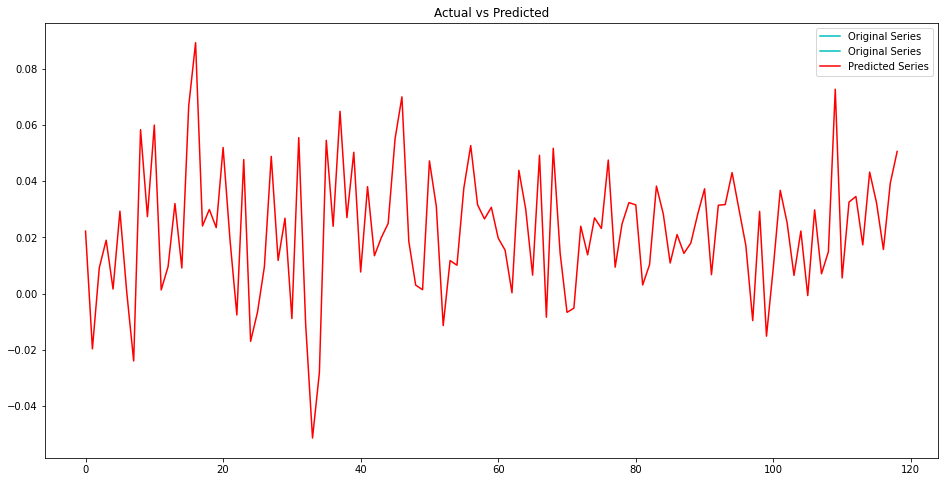

In [95]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

### Forecasting the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [96]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.predict(start='2016-01-01', end='2020-01-01') #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA[0]

0.01498673696252191

In [98]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0    0.014987
dtype: float64

In [103]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

ValueError: Length mismatch: Expected axis has 1 elements, new values have 24 elements

In [104]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = ExponentialSmoothing(forecasted_ARIMA) #use exponential function on forecasted data
forecasted_ARIMA

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

ConversionError: Failed to convert value(s) to axis units: array([<statsmodels.tsa.holtwinters.model.ExponentialSmoothing object at 0x7fb7435707c0>],
      dtype=object)

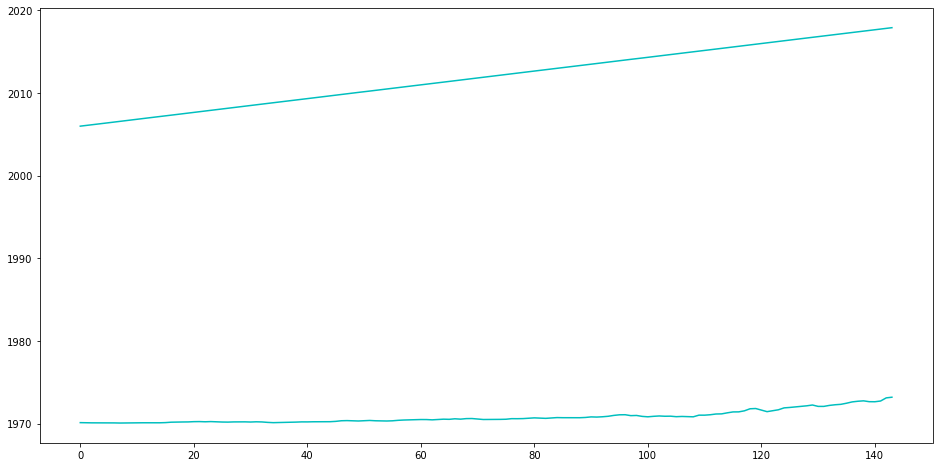

In [105]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [ ]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(df_train, predictions_ARIMA, squared=False) #calculate RMSE using the predictions_ARIMA and df_train 
error

In [ ]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(df_test, forecasted_ARIMA, squared=False)  #calculate RMSE using the forecasted_ARIMA and df_test

### Conclusion

**Write your conclusion here**

- I missed the last parts of ARIMA and couldn't figure out the coding there. But based on the previous results, ARIMA produced the smallest AIC, which would be the best model for forecasting the stock.
- Based on the ARIMA model, Amazon's stock is stable with a little upward trend.